## I. Introduction to the Problem and Dataset

In [74]:
print("Hello World!")

Hello World!


## II. Description of the dataset

## III. List of requirements

In [75]:
# Constants
dataset_path = 'Dataset 2 - Garments Dataset/garments.csv'
random_seed = 69

In [76]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

# Training and Testing the model
from sklearn.model_selection import train_test_split # For splitting the dataset into training and testing
from sklearn.pipeline import Pipeline # For creating a pipeline
from sklearn.preprocessing import StandardScaler # For Standardization
from sklearn.model_selection import RandomizedSearchCV # For Hyperparameter Tuning
from sklearn.preprocessing import PolynomialFeatures  # For Polynomial Regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score   # For evaluation
import joblib   # For saving the model

# Models
from sklearn.linear_model import LinearRegression # For Linear Regression
from sklearn.neural_network import MLPRegressor # For Neural Network

# Load the dataset from Dataset folder
og_df = pd.read_csv(dataset_path)
df = pd.read_csv(dataset_path)

## IV. Data Preprocessing and Cleaning


In [77]:
# check for NaN values
print(df.isnull().sum())

date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64


In [78]:
# check values in wip
df['wip'].value_counts()

wip
1039.0    5
1282.0    4
1079.0    3
1193.0    3
1069.0    3
         ..
357.0     1
817.0     1
1576.0    1
1262.0    1
953.0     1
Name: count, Length: 548, dtype: int64

In [79]:
# fill in the missing values with the mean of the column
df['wip'].fillna(df['wip'].mean(), inplace=True)
df['wip'].value_counts()

C:\Users\Tean Concio\AppData\Local\Temp\ipykernel_20804\4227023706.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['wip'].fillna(df['wip'].mean(), inplace=True)


wip
1190.465991    506
1039.000000      5
1282.000000      4
983.000000       3
1082.000000      3
              ... 
1674.000000      1
290.000000       1
971.000000       1
992.000000       1
1511.000000      1
Name: count, Length: 549, dtype: int64

In [80]:
# check department column
print(df['department'].unique())

# change all 'finishing ' to 'finishing'
df['department'] = df['department'].replace('finishing ', 'finishing')
df['department'] = df['department'].replace('sweing', 'sewing')
print(df['department'].unique())

['sweing' 'finishing ' 'finishing']
['sewing' 'finishing']


In [81]:
#check datatypes for all columns
print(df.dtypes)

date                      object
quarter                   object
department                object
day                       object
team                       int64
targeted_productivity    float64
smv                      float64
wip                      float64
over_time                  int64
incentive                  int64
idle_time                float64
idle_men                   int64
no_of_style_change         int64
no_of_workers            float64
actual_productivity      float64
dtype: object


In [82]:
print(df['department'].value_counts())

department
sewing       691
finishing    506
Name: count, dtype: int64


In [83]:
print(df['quarter'].value_counts())

quarter
Quarter1    360
Quarter2    335
Quarter4    248
Quarter3    210
Quarter5     44
Name: count, dtype: int64


In [84]:
print(df['day'].value_counts())

day
Wednesday    208
Sunday       203
Tuesday      201
Thursday     199
Monday       199
Saturday     187
Name: count, dtype: int64


In [85]:
print(df['team'].value_counts())

team
8     109
2     109
4     105
1     105
9     104
10    100
12     99
7      96
3      95
6      94
5      93
11     88
Name: count, dtype: int64


In [86]:
print(df['targeted_productivity'].value_counts())

targeted_productivity
0.80    540
0.70    242
0.75    216
0.65     63
0.60     57
0.50     49
0.35     27
0.40      2
0.07      1
Name: count, dtype: int64


In [87]:
print(df['smv'].value_counts())

smv
3.94     192
2.90     108
22.52    103
30.10     79
4.15      76
        ... 
38.09      1
48.18      1
30.40      1
50.89      1
20.20      1
Name: count, Length: 70, dtype: int64


In [88]:
print(df['over_time'].value_counts())

over_time
960     129
1440    111
6960     61
6840     48
1200     39
       ... 
5700      1
1680      1
1700      1
4680      1
3120      1
Name: count, Length: 143, dtype: int64


In [89]:
print(df['no_of_workers'].head())
# round down the no_of_workers
df['no_of_workers'] = np.floor(df['no_of_workers'])
print(df['no_of_workers'].head())

0    59.0
1     8.0
2    30.5
3    30.5
4    56.0
Name: no_of_workers, dtype: float64
0    59.0
1     8.0
2    30.0
3    30.0
4    56.0
Name: no_of_workers, dtype: float64


In [90]:
print(df['actual_productivity'].value_counts())
# print actual_productivity where it is < 0 or > 1
print(df[(df['actual_productivity'] < 0) | (df['actual_productivity'] > 1)])

actual_productivity
0.800402    24
0.850137    12
0.971867    12
0.850502    11
0.750651    11
            ..
0.894444     1
0.900061     1
0.909392     1
0.920000     1
0.521180     1
Name: count, Length: 879, dtype: int64
          date   quarter department        day  team  targeted_productivity  \
337  1/20/2015  Quarter3  finishing    Tuesday     5                   0.70   
437  1/26/2015  Quarter4  finishing     Monday     3                   0.75   
456  1/27/2015  Quarter4     sewing    Tuesday     2                   0.75   
457  1/27/2015  Quarter4     sewing    Tuesday     3                   0.75   
477  1/28/2015  Quarter4     sewing  Wednesday     2                   0.80   
478  1/28/2015  Quarter4     sewing  Wednesday     3                   0.80   
498  1/29/2015  Quarter5     sewing   Thursday     2                   0.80   
518  1/31/2015  Quarter5     sewing   Saturday     3                   0.80   
519  1/31/2015  Quarter5     sewing   Saturday     2             

In [91]:
# round down the actual_productivity if it is > 1
df['actual_productivity'] = np.where(df['actual_productivity'] > 1, 1, df['actual_productivity'])
print(df[(df['actual_productivity'] < 0) | (df['actual_productivity'] > 1)])

Empty DataFrame
Columns: [date, quarter, department, day, team, targeted_productivity, smv, wip, over_time, incentive, idle_time, idle_men, no_of_style_change, no_of_workers, actual_productivity]
Index: []


In [92]:
#drop date
df = df.drop('date', axis=1)

In [93]:
# check for duplicates
print(df.duplicated().sum())

0


In [94]:
#check if any numerical value is less than 0
print(df[(df.select_dtypes(include=[np.number]) < 0).any(axis=1)])

Empty DataFrame
Columns: [quarter, department, day, team, targeted_productivity, smv, wip, over_time, incentive, idle_time, idle_men, no_of_style_change, no_of_workers, actual_productivity]
Index: []


In [95]:
# print all datatypes
print(df.dtypes)

quarter                   object
department                object
day                       object
team                       int64
targeted_productivity    float64
smv                      float64
wip                      float64
over_time                  int64
incentive                  int64
idle_time                float64
idle_men                   int64
no_of_style_change         int64
no_of_workers            float64
actual_productivity      float64
dtype: object


In [96]:
# calculate overtime per worker
df['overtime_per_worker'] = df['over_time'] / df['no_of_workers']
print(df[df['overtime_per_worker'] > 120].shape)
print(df[df['overtime_per_worker'] > 240].shape)
print(df[df['overtime_per_worker'] > 420].shape)
print(df[df['overtime_per_worker'] > 600].shape)

(490, 15)
(70, 15)
(16, 15)
(2, 15)


In [97]:
# print all idle_men with decimal values
print(df[df['idle_men'] % 1 != 0])

Empty DataFrame
Columns: [quarter, department, day, team, targeted_productivity, smv, wip, over_time, incentive, idle_time, idle_men, no_of_style_change, no_of_workers, actual_productivity, overtime_per_worker]
Index: []


In [98]:
#print all rows with idle time = 0 and idle_men > 0
print(df[(df['idle_time'] == 0) & (df['idle_men'] > 0)])

Empty DataFrame
Columns: [quarter, department, day, team, targeted_productivity, smv, wip, over_time, incentive, idle_time, idle_men, no_of_style_change, no_of_workers, actual_productivity, overtime_per_worker]
Index: []


In [99]:
# turn department, day, and quarter into one-hot encoding
df_cleaned = df.copy()
df = pd.get_dummies(df, columns=['department', 'day', 'quarter'])
# print all datatypes
print(df.dtypes)

team                       int64
targeted_productivity    float64
smv                      float64
wip                      float64
over_time                  int64
incentive                  int64
idle_time                float64
idle_men                   int64
no_of_style_change         int64
no_of_workers            float64
actual_productivity      float64
overtime_per_worker      float64
department_finishing        bool
department_sewing           bool
day_Monday                  bool
day_Saturday                bool
day_Sunday                  bool
day_Thursday                bool
day_Tuesday                 bool
day_Wednesday               bool
quarter_Quarter1            bool
quarter_Quarter2            bool
quarter_Quarter3            bool
quarter_Quarter4            bool
quarter_Quarter5            bool
dtype: object


In [100]:
#check for days where there are no incentives but have overtime (trim to targeted_productivity, idle_men, idle_time, and actual_productivity)
df[(df['incentive'] == 0) & (df['over_time'] > 0)][['targeted_productivity', 'idle_men', 'idle_time', 'actual_productivity', 'incentive', 'over_time', 'wip', 'smv']]

,targeted_productivity,idle_men,idle_time,actual_productivity,incentive,over_time,wip,smv
1,0.75,0,0.0,0.886500,0,960,1190.465991,3.94
6,0.75,0,0.0,0.755167,0,960,1190.465991,3.94
13,0.65,0,0.0,0.705917,0,960,1190.465991,3.94
14,0.75,0,0.0,0.676667,0,960,1190.465991,2.90
15,0.75,0,0.0,0.593056,0,2160,1190.465991,3.94
...,...,...,...,...,...,...,...,...
1192,0.75,0,0.0,0.628333,0,960,1190.465991,2.90
1193,0.70,0,0.0,0.625625,0,960,1190.465991,3.90
1194,0.65,0,0.0,0.625625,0,960,1190.465991,3.90
1195,0.75,0,0.0,0.505889,0,1800,1190.465991,2.90


In [101]:
#check cleaned dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   team                   1197 non-null   int64  
 1   targeted_productivity  1197 non-null   float64
 2   smv                    1197 non-null   float64
 3   wip                    1197 non-null   float64
 4   over_time              1197 non-null   int64  
 5   incentive              1197 non-null   int64  
 6   idle_time              1197 non-null   float64
 7   idle_men               1197 non-null   int64  
 8   no_of_style_change     1197 non-null   int64  
 9   no_of_workers          1197 non-null   float64
 10  actual_productivity    1197 non-null   float64
 11  overtime_per_worker    1197 non-null   float64
 12  department_finishing   1197 non-null   bool   
 13  department_sewing      1197 non-null   bool   
 14  day_Monday             1197 non-null   bool   
 15  day_

# V. Exploratory Data Analysis

## V-A. Correlation and Distribution of Numerical Features (Seal)

In [102]:
df.head()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,...,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,quarter_Quarter1,quarter_Quarter2,quarter_Quarter3,quarter_Quarter4,quarter_Quarter5
0,8,0.80,26.16,1108.000000,7080,98,0.0,0,0,59.0,...,False,False,True,False,False,True,False,False,False,False
1,1,0.75,3.94,1190.465991,960,0,0.0,0,0,8.0,...,False,False,True,False,False,True,False,False,False,False
2,11,0.80,11.41,968.000000,3660,50,0.0,0,0,30.0,...,False,False,True,False,False,True,False,False,False,False
3,12,0.80,11.41,968.000000,3660,50,0.0,0,0,30.0,...,False,False,True,False,False,True,False,False,False,False
4,6,0.80,25.90,1170.000000,1920,50,0.0,0,0,56.0,...,False,False,True,False,False,True,False,False,False,False


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   team                   1197 non-null   int64  
 1   targeted_productivity  1197 non-null   float64
 2   smv                    1197 non-null   float64
 3   wip                    1197 non-null   float64
 4   over_time              1197 non-null   int64  
 5   incentive              1197 non-null   int64  
 6   idle_time              1197 non-null   float64
 7   idle_men               1197 non-null   int64  
 8   no_of_style_change     1197 non-null   int64  
 9   no_of_workers          1197 non-null   float64
 10  actual_productivity    1197 non-null   float64
 11  overtime_per_worker    1197 non-null   float64
 12  department_finishing   1197 non-null   bool   
 13  department_sewing      1197 non-null   bool   
 14  day_Monday             1197 non-null   bool   
 15  day_

In [104]:
df.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,overtime_per_worker
count,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.551378,0.734461,148.533406
std,3.463963,0.097891,10.943219,1395.647261,3348.823563,160.182643,12.709757,3.268987,0.427848,22.152559,0.173380,86.042508
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705,0.000000
25%,3.000000,0.700000,3.940000,970.000000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307,120.000000
50%,6.000000,0.750000,15.260000,1190.465991,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333,120.000000
75%,9.000000,0.800000,24.260000,1190.465991,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253,180.000000
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.000000,720.000000


In [105]:
def plot_numerics(data):
    numeric_columns = data.columns
    # Plotting histograms and box plots for each numeric column
    for column in numeric_columns:
        _, ax = plt.subplots(1,2, figsize=(16, 5))
        ax=ax.flatten()
        # Histogram
        sns.histplot(data[column], bins=50, kde=True, color='skyblue', ax=ax[0])
        ax[0].set_title(f'Histogram of {column}', fontsize=15,fontweight='bold')
        ax[0].set_xlabel(column, fontsize=12)
        ax[0].set_ylabel('Frequency', fontsize=12)
        # Box plot
        sns.boxplot(x=data[column], color='#FFEE8C', ax=ax[1])
        ax[1].set_title(f'Box plot of {column}', fontsize=15,fontweight='bold')
        ax[1].set_xlabel(column, fontsize=12)
        plt.tight_layout()
        plt.show()

In [106]:
df.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,overtime_per_worker
count,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.551378,0.734461,148.533406
std,3.463963,0.097891,10.943219,1395.647261,3348.823563,160.182643,12.709757,3.268987,0.427848,22.152559,0.173380,86.042508
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705,0.000000
25%,3.000000,0.700000,3.940000,970.000000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307,120.000000
50%,6.000000,0.750000,15.260000,1190.465991,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333,120.000000
75%,9.000000,0.800000,24.260000,1190.465991,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253,180.000000
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.000000,720.000000


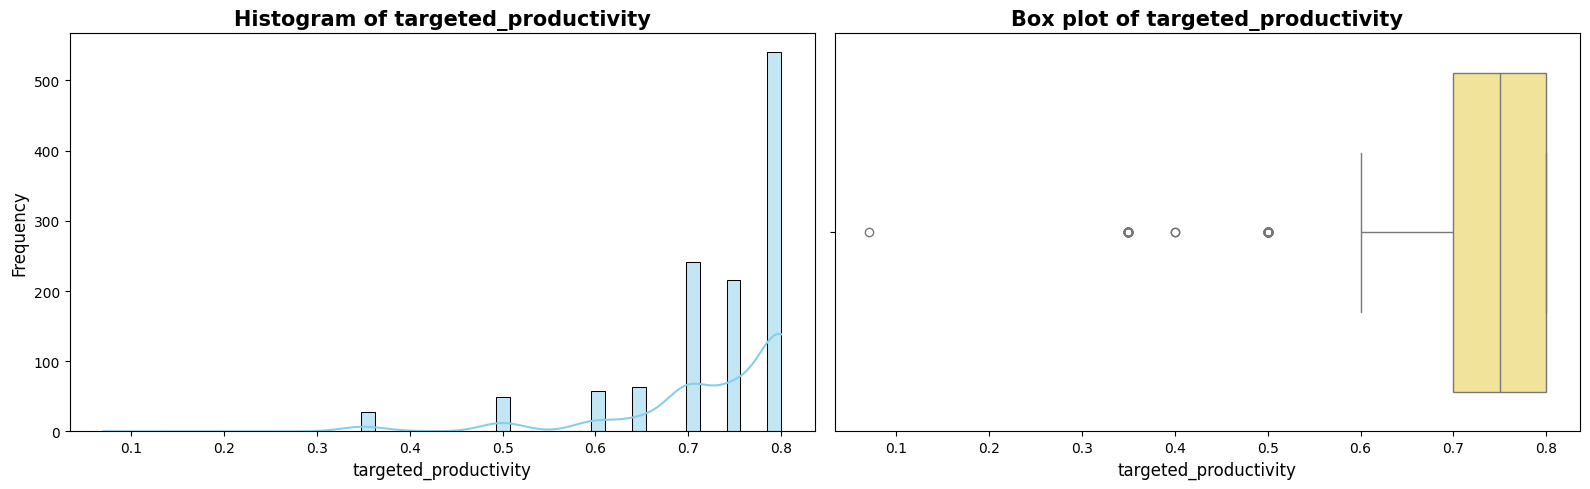

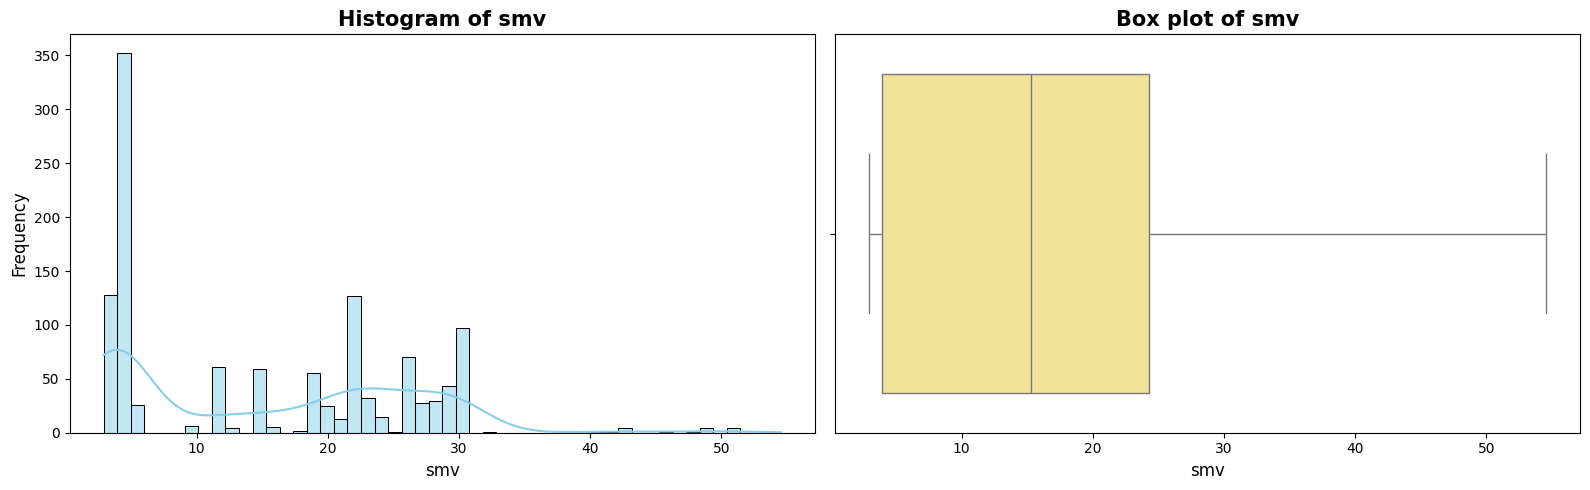

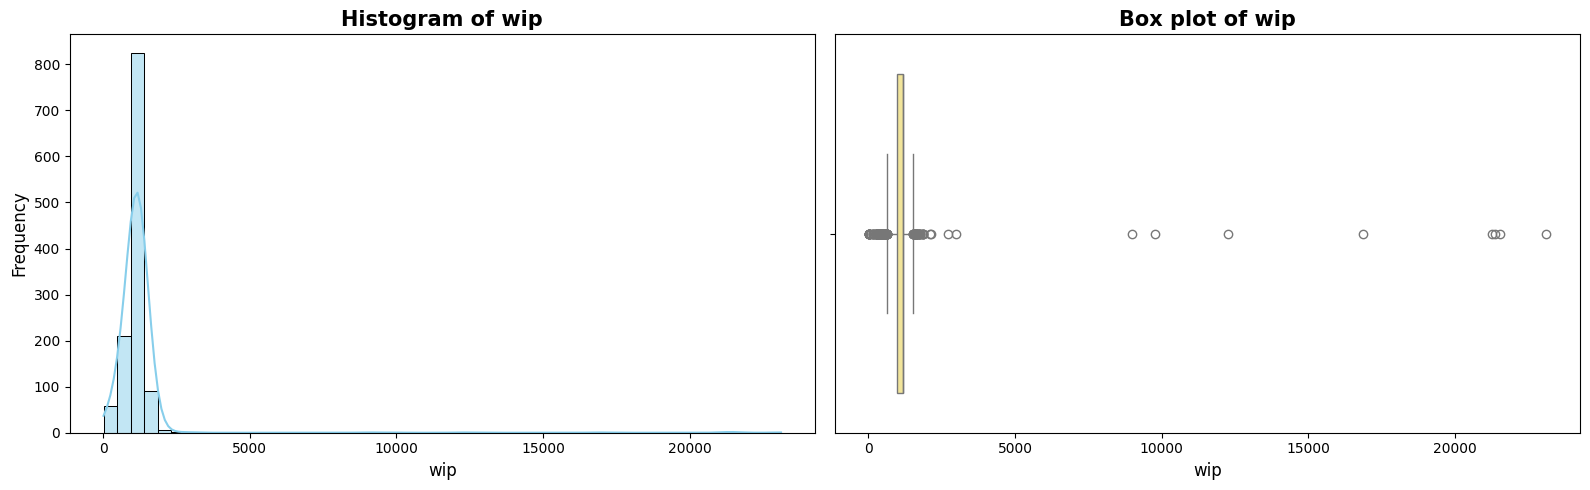

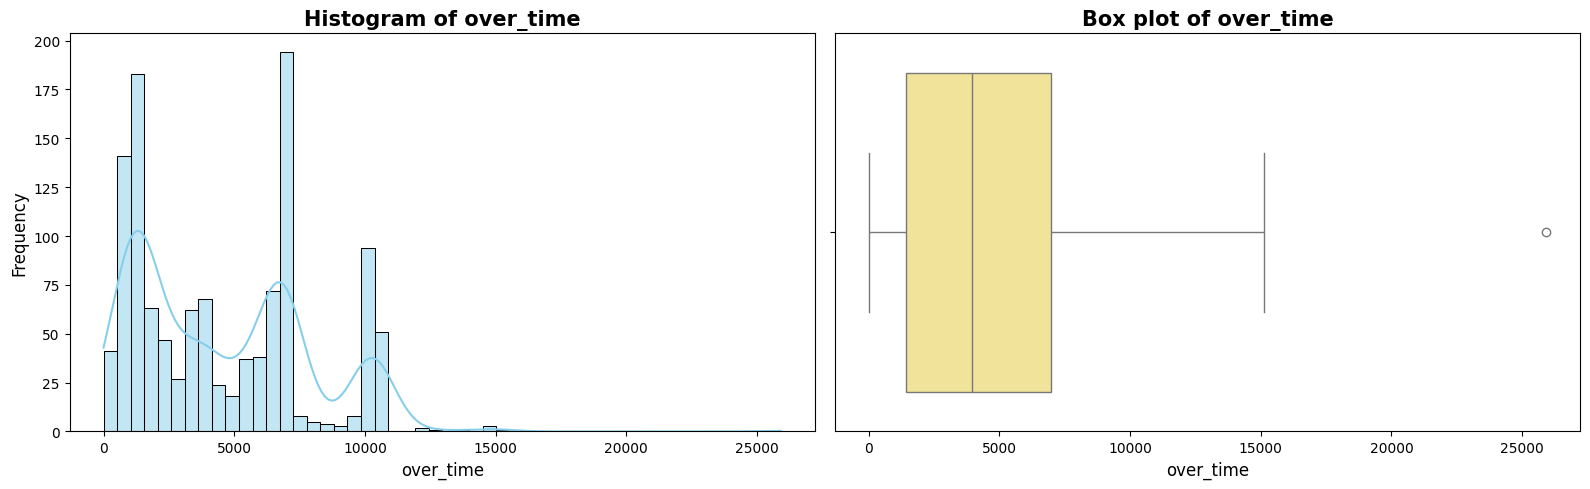

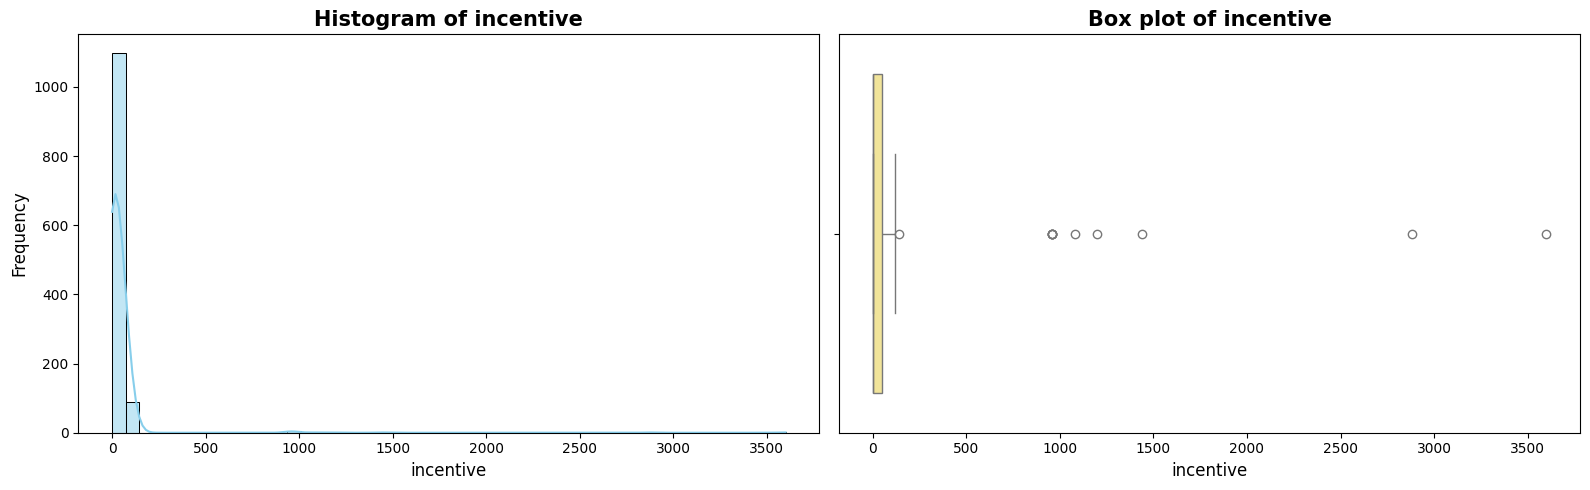

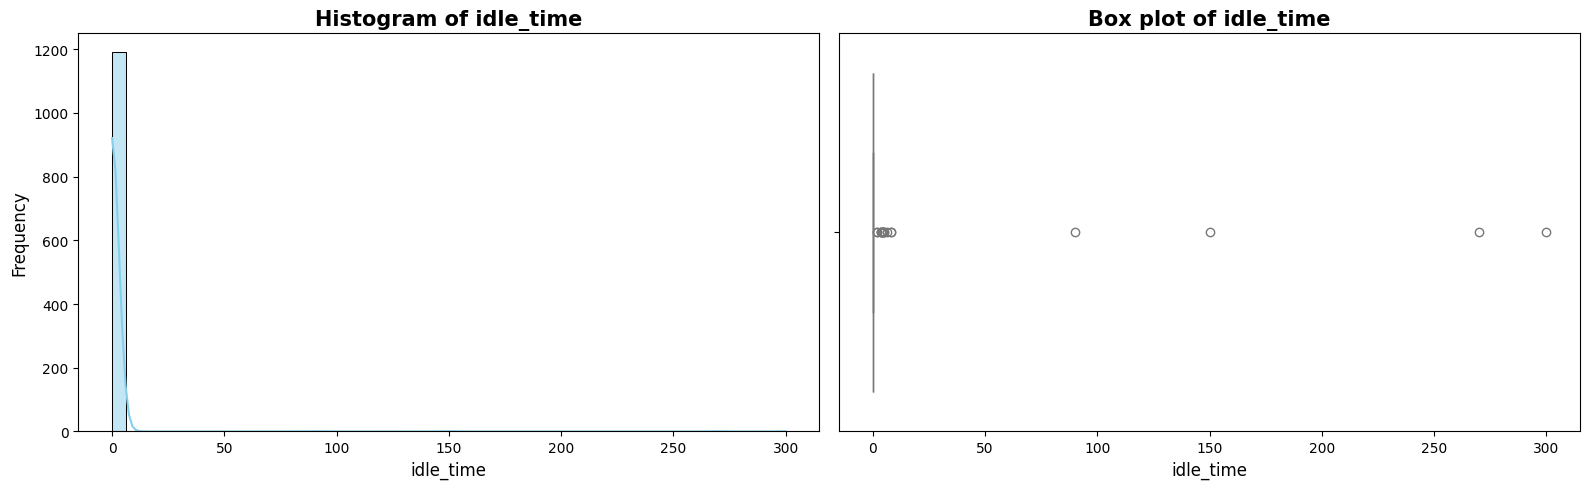

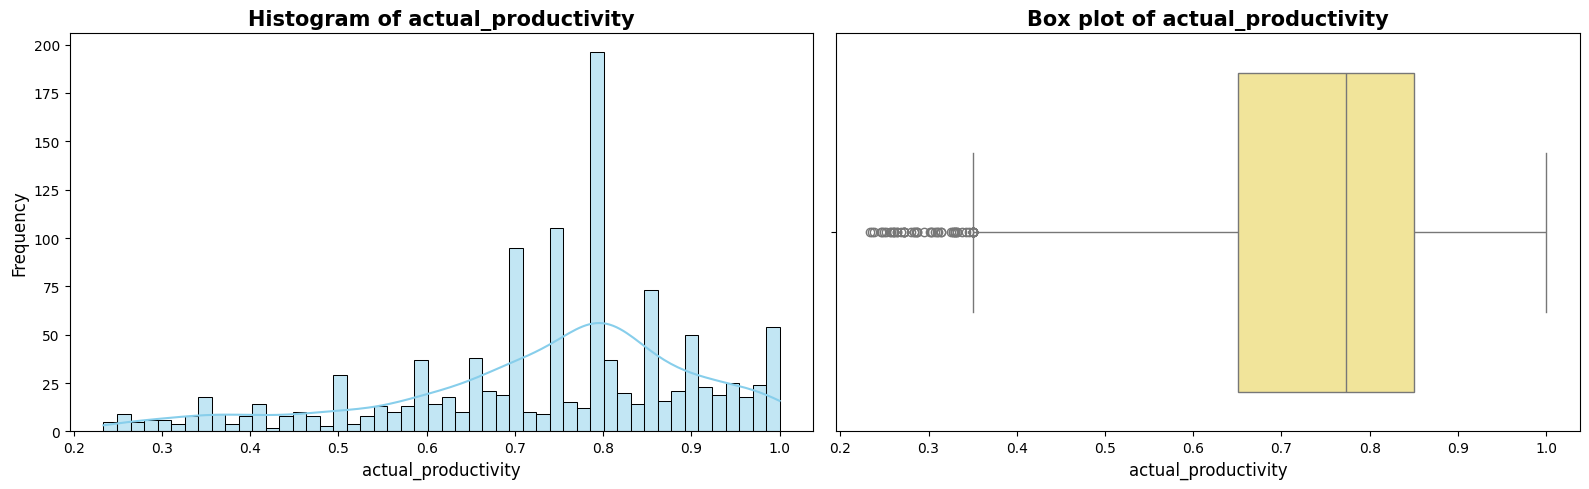

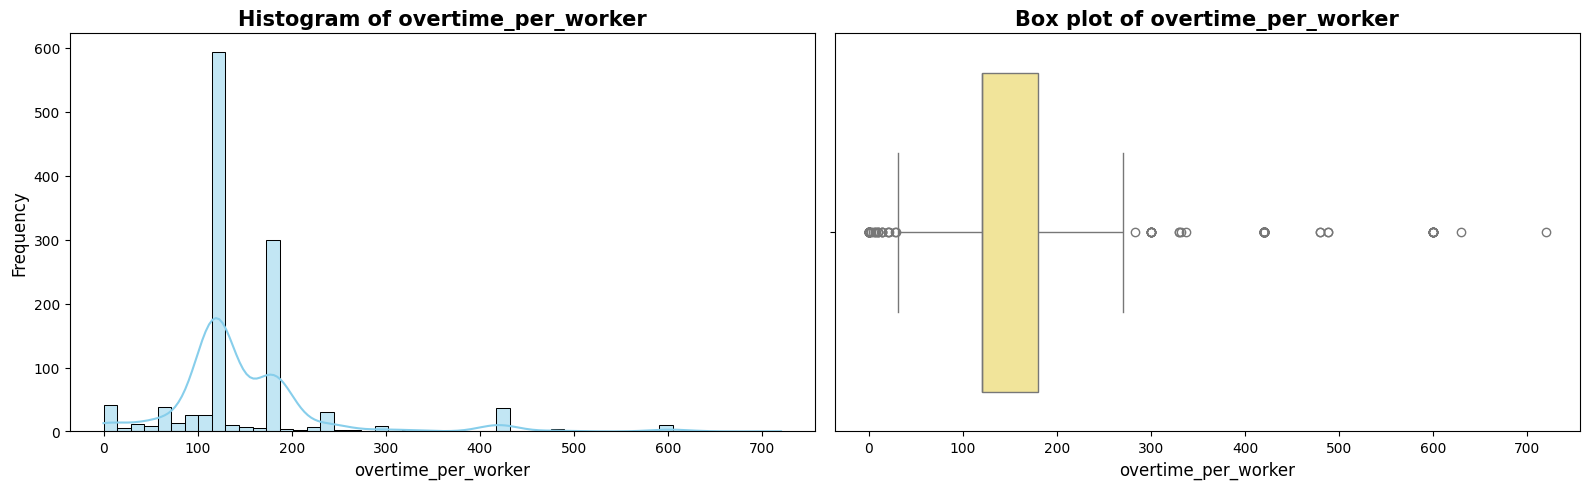

In [107]:
num_cols = ['targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'actual_productivity', 'overtime_per_worker']
plot_numerics(df[num_cols])

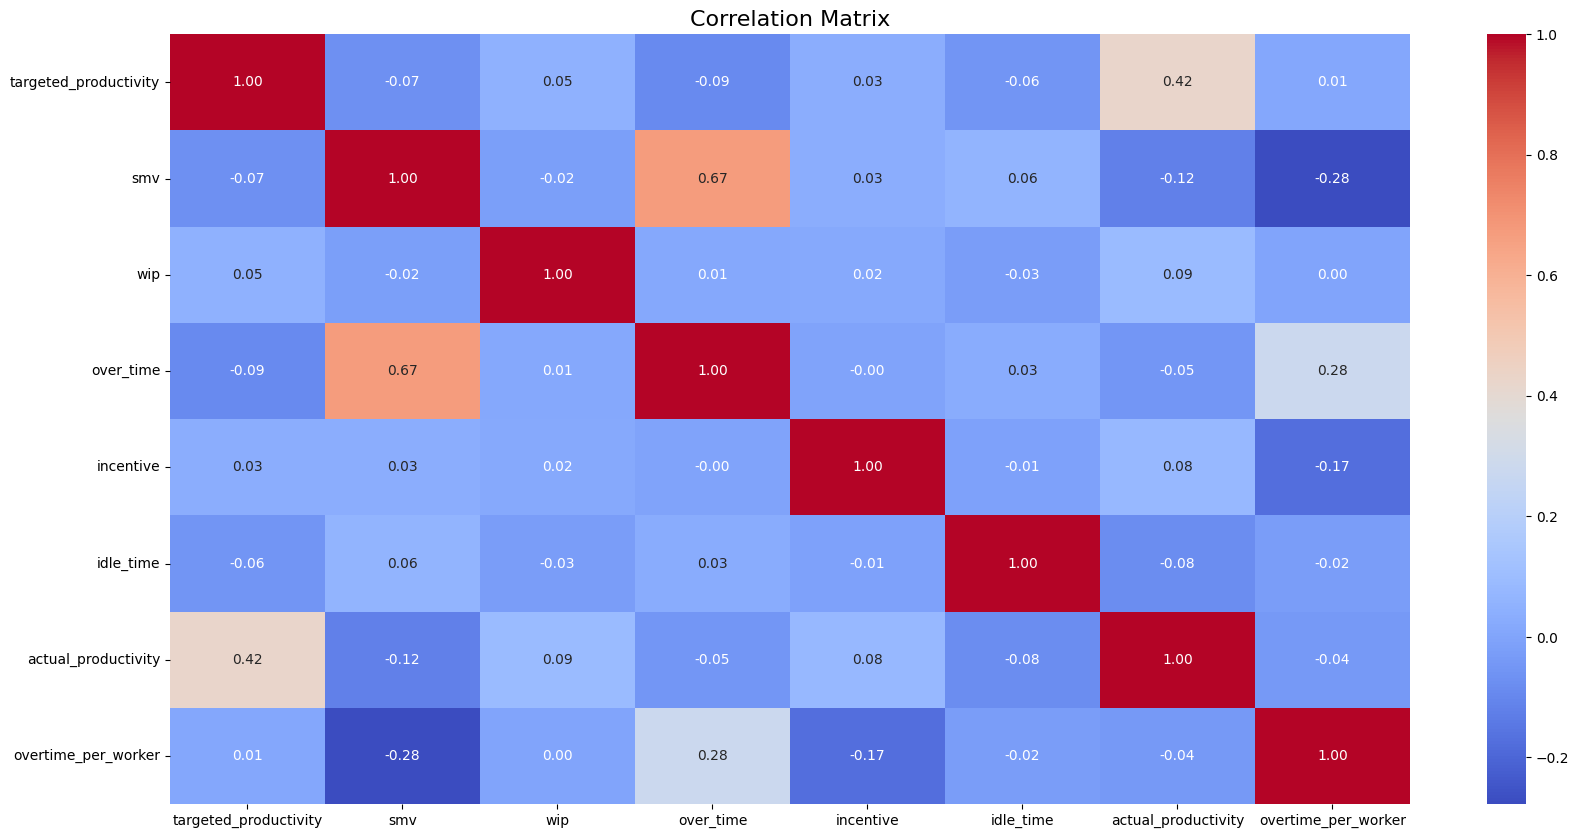

In [108]:
correlation_matrix = df[num_cols].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix", fontsize=16)
plt.show()

## V-B. Productivity with regards to Teams and Departments (Orrin)

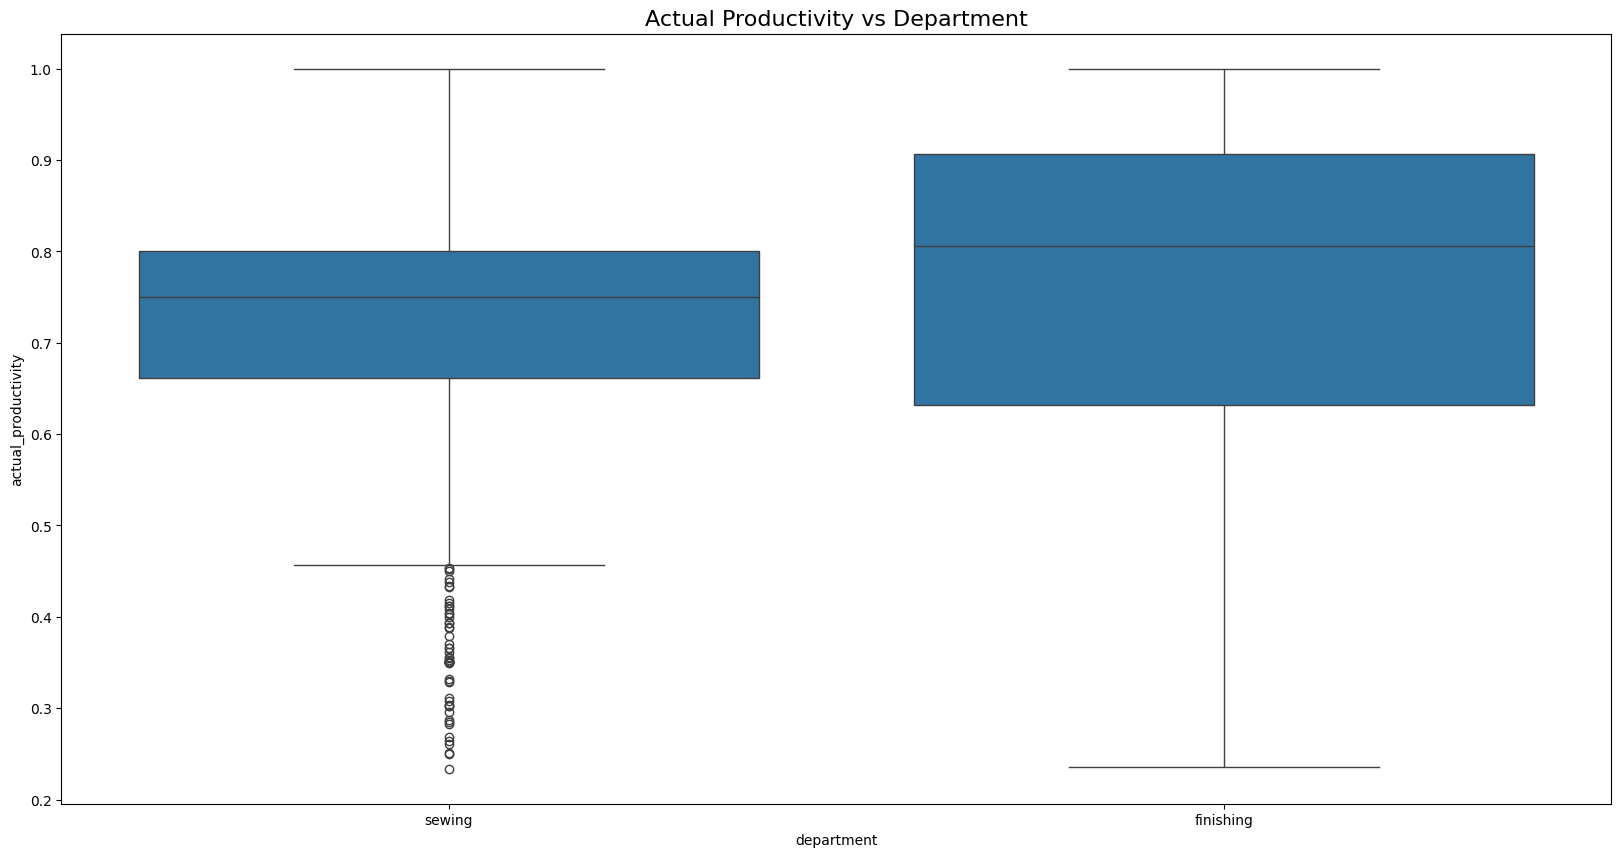

In [109]:
# actual productivity vs department
plt.figure(figsize=(20, 10))
sns.boxplot(x='department', y='actual_productivity', data=df_cleaned)
plt.title("Actual Productivity vs Department", fontsize=16)
plt.show()

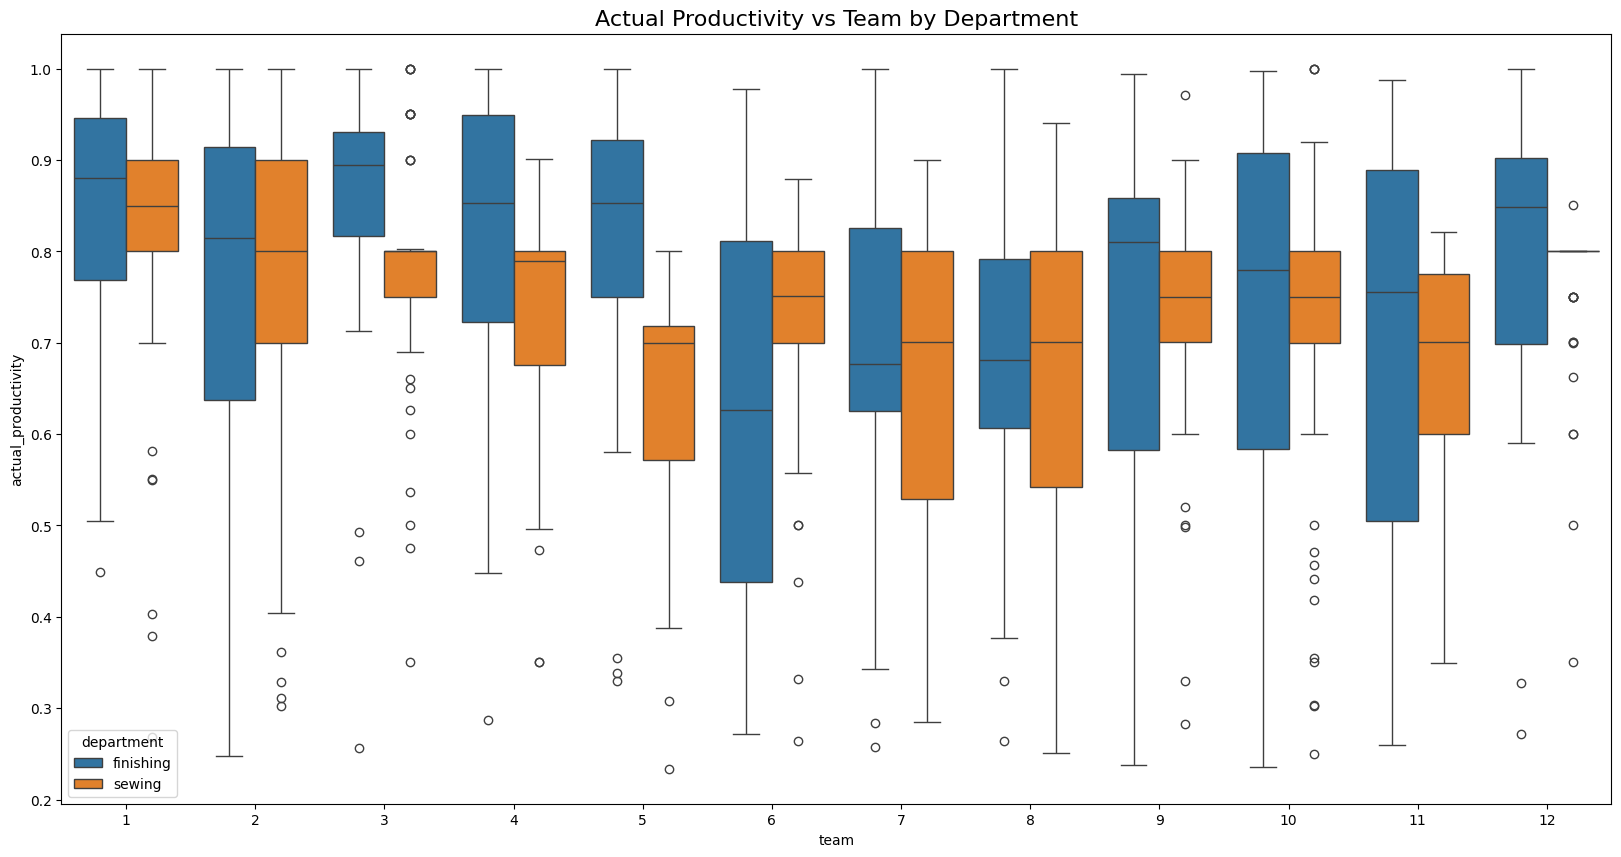

In [110]:
# actual productivity vs team by department
plt.figure(figsize=(20, 10))
sns.boxplot(x='team', y='actual_productivity', hue='department', data=df_cleaned)
plt.title("Actual Productivity vs Team by Department", fontsize=16)
plt.show()

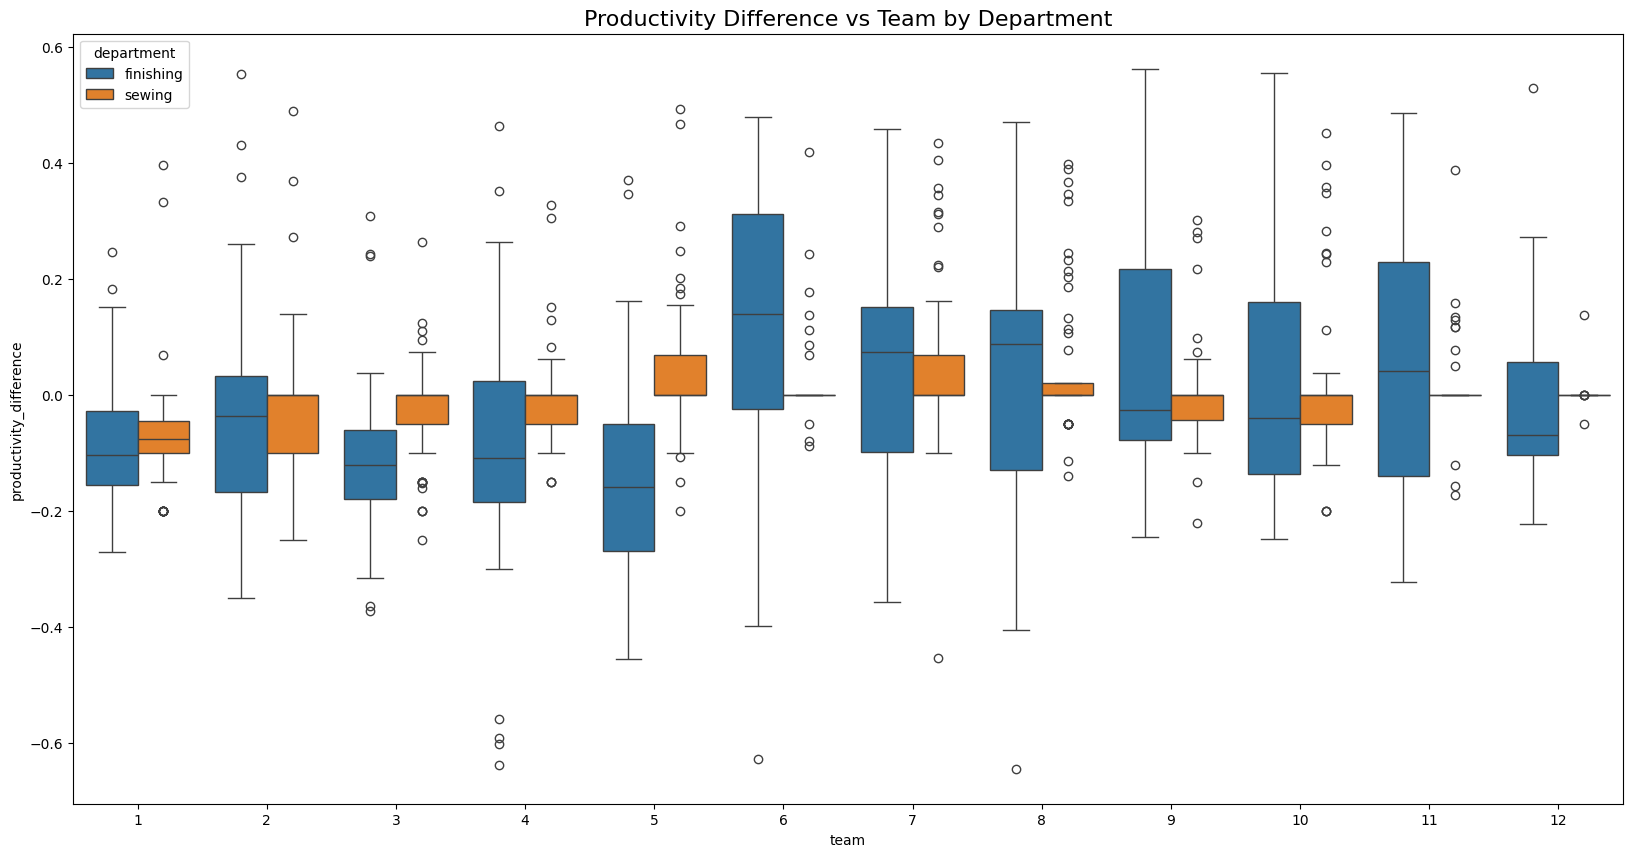

In [111]:
# productivity diff per team by department
df_cleaned['productivity_difference'] = df_cleaned['targeted_productivity'] - df_cleaned['actual_productivity']
plt.figure(figsize=(20, 10))
sns.boxplot(x='team', y='productivity_difference', hue='department', data=df_cleaned)
plt.title("Productivity Difference vs Team by Department", fontsize=16)
plt.show()

Lower numbered teams tend to be unable to reach productivity targets.

In [112]:
# number of workers per team by department in table format
workers_per_team = df_cleaned.groupby(['team', 'department'])['no_of_workers'].mean().reset_index()
workers_per_team = workers_per_team.pivot(index='team', columns='department', values='no_of_workers')
workers_per_team

department,finishing,sewing
team,,
1,9.673469,57.142857
2,11.673077,55.368421
3,12.243243,56.862069
4,13.456522,57.305085
5,9.742857,57.206897
6,9.000000,34.661017
7,9.926829,57.218182
8,9.075472,56.446429
9,8.869565,56.086207


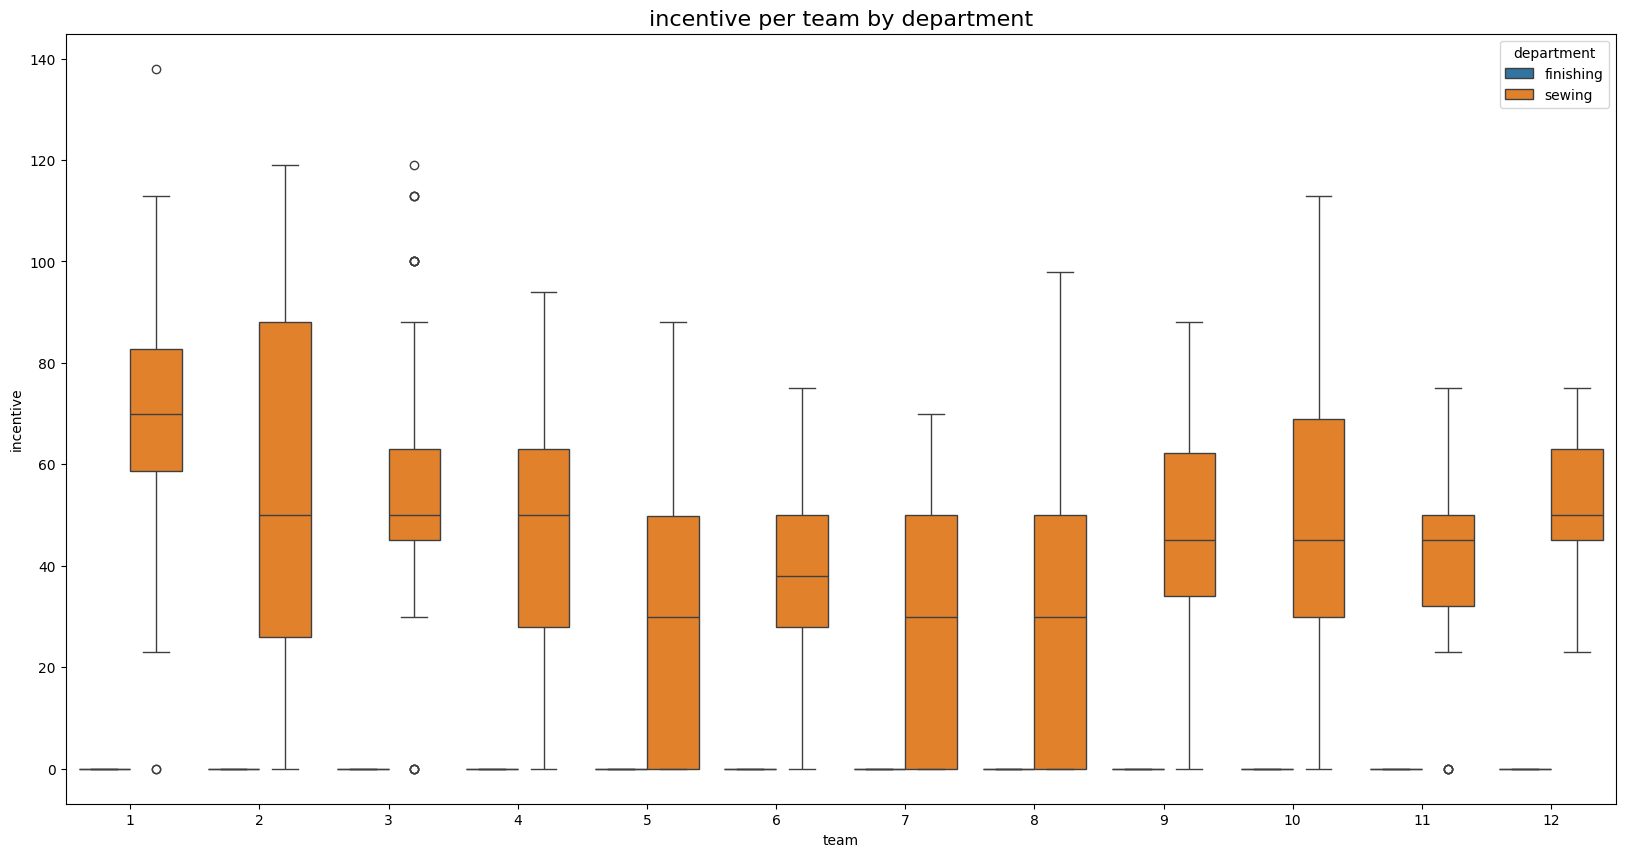

In [113]:
#could the issue be related to incentives?
df2 = df_cleaned.copy()
# remove incentive outliers
df2 = df2[df2['incentive'] < 700]

plt.figure(figsize=(20, 10))
sns.boxplot(x='team', y='incentive', hue='department', data=df2)
plt.title("incentive per team by department", fontsize=16)
plt.show()

Finishing team does not get incentives

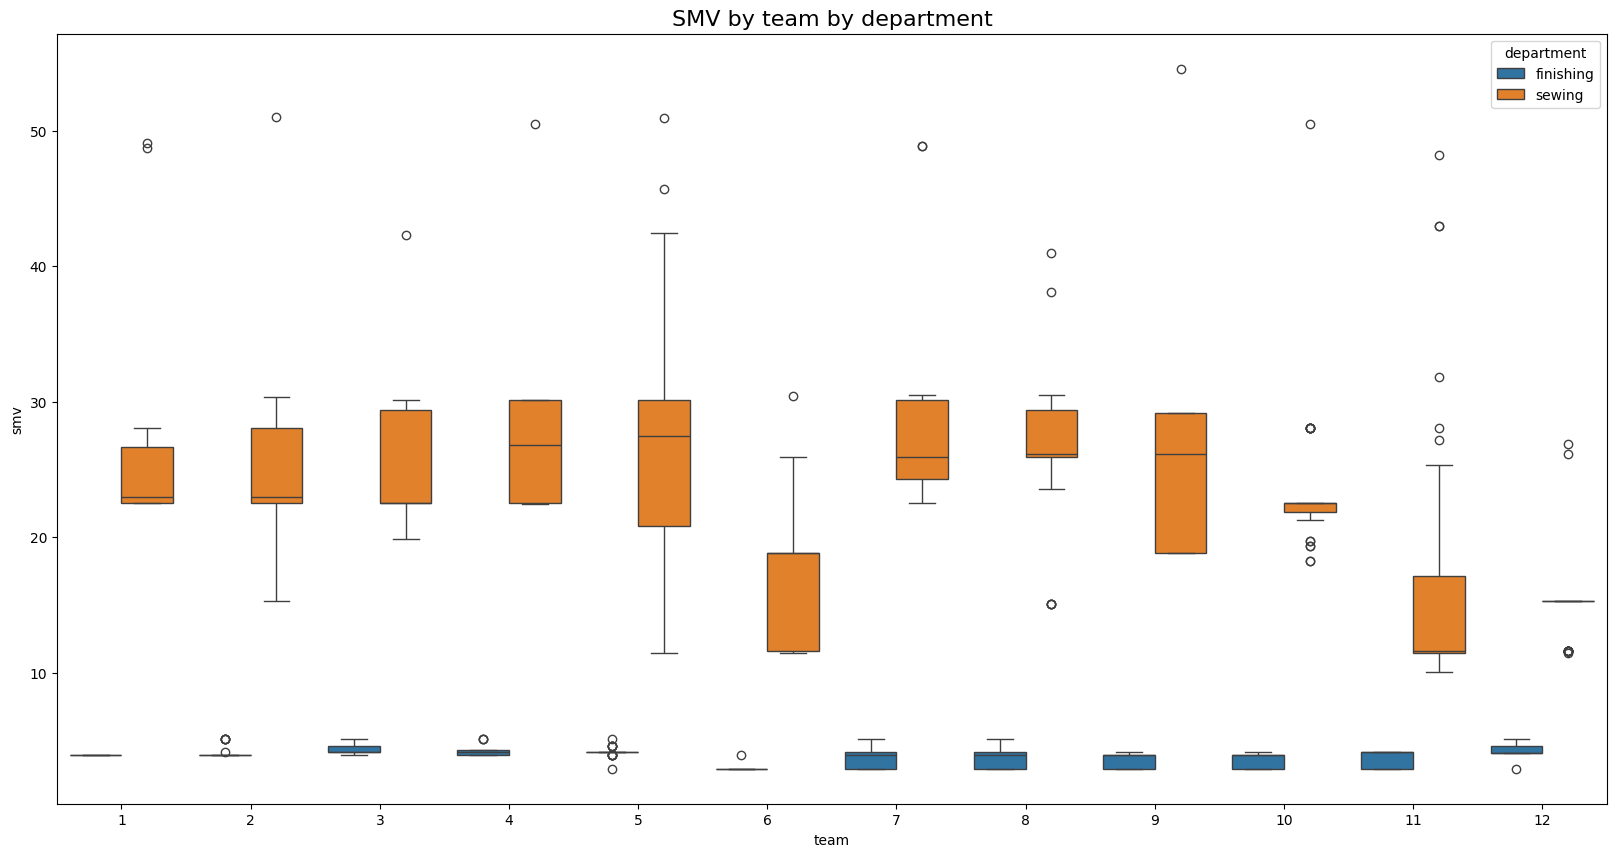

In [114]:
#perhaps the issue is in the smv
plt.figure(figsize=(20, 10))
sns.boxplot(x='team', y='smv', hue='department', data=df_cleaned)
plt.title("SMV by team by department", fontsize=16)
plt.show()

## V-C. Day of the Week and Quarter of the Month to Actual Productivity (Tean)

### Description

In the Philippines, a company typically pays its workers at the end of the 2nd and 4th week of every month. With this, it can be speculated that the actual productivity of the workers will be affected when in the proximity of those times as they anticipate receiving their paychecks. Additionally, with the chosen representation, it will also be possible to analyze actual productivity as the month goes by.

Relevant fields of the EDA:

Days of the Week:
- 'day_Monday'
- 'day_Tuesday'
- 'day_Wednesday'
- 'day_Thursday'
- 'day_Saturday'
- 'day_Sunday'

Quarters of the Month:
- 'quarter_Quarter1'
- 'quarter_Quarter2'
- 'quarter_Quarter3'
- 'quarter_Quarter4'
- 'quarter_Quarter5'

Actual Productivity:
- 'actual_productivity'

### Data Transformation

Seclude the relevant fields for the EDA.

In [115]:
day_quarter_productivity_df = df[['day_Monday', 'day_Tuesday', 'day_Wednesday', 'day_Thursday', 'day_Saturday', 'day_Sunday', 'quarter_Quarter1', 'quarter_Quarter2', 'quarter_Quarter3', 'quarter_Quarter4', 'quarter_Quarter5', 'actual_productivity']]

day_quarter_productivity_df

,day_Monday,day_Tuesday,day_Wednesday,day_Thursday,day_Saturday,day_Sunday,quarter_Quarter1,quarter_Quarter2,quarter_Quarter3,quarter_Quarter4,quarter_Quarter5,actual_productivity
0,False,False,False,True,False,False,True,False,False,False,False,0.940725
1,False,False,False,True,False,False,True,False,False,False,False,0.886500
2,False,False,False,True,False,False,True,False,False,False,False,0.800570
3,False,False,False,True,False,False,True,False,False,False,False,0.800570
4,False,False,False,True,False,False,True,False,False,False,False,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...
1192,False,False,True,False,False,False,False,True,False,False,False,0.628333
1193,False,False,True,False,False,False,False,True,False,False,False,0.625625
1194,False,False,True,False,False,False,False,True,False,False,False,0.625625
1195,False,False,True,False,False,False,False,True,False,False,False,0.505889


Transform the relevant fields into more easily processable values.

In [116]:
# Ensure we are working with a copy of the DataFrame
day_quarter_productivity_df = day_quarter_productivity_df.copy()

# Make day_of_week and quarter columns
day_quarter_productivity_df.loc[:, 'day_of_week'] = day_quarter_productivity_df[['day_Monday', 'day_Tuesday', 'day_Wednesday', 'day_Thursday', 'day_Saturday', 'day_Sunday']].idxmax(axis=1).str.split('_').str[1]
day_quarter_productivity_df.loc[:, 'quarter'] = day_quarter_productivity_df[['quarter_Quarter1', 'quarter_Quarter2', 'quarter_Quarter3', 'quarter_Quarter4', 'quarter_Quarter5']].idxmax(axis=1).str.split('_').str[1]

# Drop the one-hot encoded columns
day_quarter_productivity_df = day_quarter_productivity_df.drop(['day_Monday', 'day_Tuesday', 'day_Wednesday', 'day_Thursday', 'day_Saturday', 'day_Sunday', 'quarter_Quarter1', 'quarter_Quarter2', 'quarter_Quarter3', 'quarter_Quarter4', 'quarter_Quarter5'], axis=1)

day_quarter_productivity_df

,actual_productivity,day_of_week,quarter
0,0.940725,Thursday,Quarter1
1,0.886500,Thursday,Quarter1
2,0.800570,Thursday,Quarter1
3,0.800570,Thursday,Quarter1
4,0.800382,Thursday,Quarter1
...,...,...,...
1192,0.628333,Wednesday,Quarter2
1193,0.625625,Wednesday,Quarter2
1194,0.625625,Wednesday,Quarter2
1195,0.505889,Wednesday,Quarter2


### Data Representation and Visualization

Pivot Tables specialize in representing grouped data of many dimensions into a neat table format, where the rows and columns are the groupings and the cells are the featured values.
As the EDA features 1 quantitative and 2 qualitative features, a Pivot Table should be the most fitting representation. 
This lets us create a table who's columns are the days of the week, rows are the quarters of the month, and cells are the means of the actual productivities grouped by the columns and rows.

In [117]:
# Create a pivot table
pivot_table = day_quarter_productivity_df.pivot_table(
    values='actual_productivity', 
    index='quarter', 
    columns='day_of_week', 
    aggfunc='mean'
)

# Sort the days of the week
pivot_table = pivot_table[['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday']]

pivot_table

day_of_week,Sunday,Monday,Tuesday,Wednesday,Thursday,Saturday
quarter,,,,,,
Quarter1,0.744070,0.746133,0.751094,0.755135,0.749143,0.761843
Quarter2,0.748086,0.739473,0.760480,0.738996,0.719283,0.741212
Quarter3,0.677855,0.706273,0.700208,0.695238,0.722660,0.730730
Quarter4,0.716707,0.737127,0.737412,0.712093,0.654613,0.700899
Quarter5,NaN,NaN,NaN,NaN,0.791633,0.854926


To better visualize the Pivot Table, a Heat Map can be made to highlight the trends of the data in each grouping.

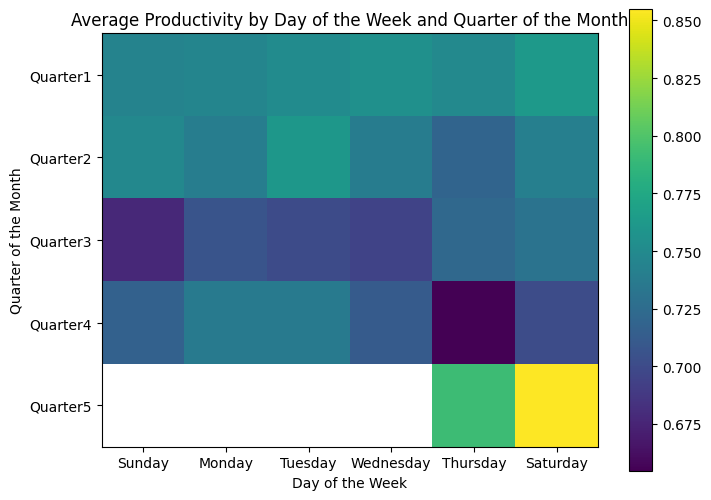

In [118]:
# Plot the pivot table
plt.figure(figsize=(8, 6))
plt.imshow(pivot_table, cmap='viridis')
plt.colorbar()
plt.xticks(np.arange(6), pivot_table.columns)
plt.yticks(np.arange(5), pivot_table.index)
plt.xlabel('Day of the Week')
plt.ylabel('Quarter of the Month')
plt.title('Average Productivity by Day of the Week and Quarter of the Month')
plt.show()

### Findings

- Actual productivity of workers decreases as the month goes by, with the later half of the month being darker than the start. 
- The start of Quarter 3 (0.677855) and the end of Quarter 4 (0.654613) are especially dark, suggesting that the workers are less productive after receiving their 1st monthly paycheck and before receiving their 2nd monthly paycheck.
- Quarter 5 is very productive as its colors are way brighter. However, this may be an outlier due to the only Quarter 5 days being 1/29/2015 (0.791633) and 1/31/2025 (0.854926).

## V-D. SMV to Number of Workers and Overtime

In [119]:
test_df = df[(df["smv"] == 0)]

test_df

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,...,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,quarter_Quarter1,quarter_Quarter2,quarter_Quarter3,quarter_Quarter4,quarter_Quarter5


In [120]:
smv_nw_overtime_df = df[['smv', 'no_of_workers', 'over_time', 'overtime_per_worker', 'actual_productivity']]

In [121]:
smv_nw_overtime_df = smv_nw_overtime_df.copy()

smv_nw_overtime_df

,smv,no_of_workers,over_time,overtime_per_worker,actual_productivity
0,26.16,59.0,7080,120.000000,0.940725
1,3.94,8.0,960,120.000000,0.886500
2,11.41,30.0,3660,122.000000,0.800570
3,11.41,30.0,3660,122.000000,0.800570
4,25.90,56.0,1920,34.285714,0.800382
...,...,...,...,...,...
1192,2.90,8.0,960,120.000000,0.628333
1193,3.90,8.0,960,120.000000,0.625625
1194,3.90,8.0,960,120.000000,0.625625
1195,2.90,15.0,1800,120.000000,0.505889


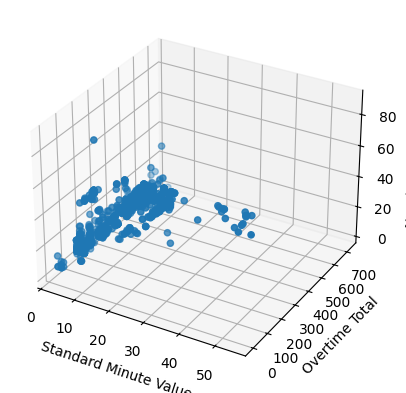

In [122]:
x = smv_nw_overtime_df['smv']
z = smv_nw_overtime_df['no_of_workers']
y = smv_nw_overtime_df['overtime_per_worker']

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x, y, z)

ax.set_xlabel('Standard Minute Value')
#plt.ylabel('Number of Workers')
ax.set_ylabel('Overtime Total')
ax.set_zlabel('Number of Workers')

plt.show()

# VI. Initial Model Training

## VI-0. Train Test Set Separation

`X` is the feature table and will all features except `actual_productivity`.

`y` is the label of the feature table and will only contain `actual_productivity`.

In [123]:
X = df.drop(columns=['actual_productivity']).values
y = df['actual_productivity'].values

print('X ', X.shape)
print('y ', y.shape)

X  (1197, 24)
y  (1197,)


Divide the dataset into train and test sets, where `20%` of the data will be placed in the test set.

Random state is set to `69` for uniformity.

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

Display the shape of the train, validation, and test sets.

In [125]:
print('X_train', X_train.shape)
print('y_train', y_train.shape)

print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (957, 24)
y_train (957,)
X_test (240, 24)
y_test (240,)


Standardize the values based on X_train if needed.

In [126]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Function to display Score, MSE, RMSE, MAE, and R2 given a regressor

In [127]:
def getModelPerformance(model, model_name:str, scaled:bool):
    
    # Predictions
    if scaled:
        train_score = model.score(X_train_scaled, y_train)
        test_score = model.score(X_test_scaled, y_test)
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)
        
    else:
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

    # MSE
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    print(model_name + ' Train Score:', train_score)
    print(model_name + ' Test Score:', test_score)
    print('')
    print(model_name + ' Train MSE:', train_mse)
    print(model_name + ' Test MSE:', test_mse)
    print('')
    print(model_name + ' Train RMSE:', np.sqrt(train_mse))
    print(model_name + ' Test RMSE:', np.sqrt(test_mse))
    print('')
    print(model_name + ' Train MAE:', mean_absolute_error(y_train, y_train_pred))
    print(model_name + ' Test MAE:', mean_absolute_error(y_test, y_test_pred))
    print('')
    print(model_name + ' Train R^2:', r2_score(y_train, y_train_pred))
    print(model_name + ' Test R^2:', r2_score(y_test, y_test_pred))

## VI-A. Linear Regression

In [128]:
linear_regression = LinearRegression()
linear_regression.fit(X_train_scaled, y_train)

LinearRegression()

In [129]:
y_predicted = linear_regression.predict(X_test_scaled)
rmse = np.sqrt(np.mean((y_predicted - y_test) ** 2))
print(f'Root Mean Squared Error: {rmse}')

# plot with actual productivity and predicted productivity in different colors
# plt.figure(figsize=(8, 6))
# plt.scatter(scaled_y_val, y_predicted, color='red', label='Predicted Values')  
# plt.scatter(scaled_y_val, scaled_y_val, color='green', label='Actual Values')  
# min_val = min(scaled_y_val.min(), y_predicted.min())
# max_val = max(scaled_y_val.max(), y_predicted.max())
# plt.plot([min_val, max_val], [min_val, max_val], color='blue', linestyle='--', label='Ideal Fit (Actual = Predicted)')
# plt.xlabel('Actual Productivity')
# plt.ylabel('Predicted Productivity')
# plt.title('Actual Productivity vs Predicted Productivity')
# plt.legend()
# plt.grid()
# plt.show()


Root Mean Squared Error: 0.15425397542237063


In [130]:
# linear regression with polyfit
poly = PolynomialFeatures(degree=2)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

print('X_poly', X_train_poly.shape)
print('X_test_poly', X_test_poly.shape)

X_poly (957, 325)
X_test_poly (240, 325)


In [131]:
model = linear_regression.fit(X_train_poly, y_train)
y_predicted = model.predict(X_test_poly)
rmse = np.sqrt(np.mean((y_predicted - y_test) ** 2))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.3746132328457125


## VI-B. Decision Trees

Justification of Random Forest

Hyper Parameters and Tuning process

In [132]:
import sklearn.ensemble
from sklearn import metrics
#rf_regressor = sklearn.ensemble.RandomForestRegressor(n_estimators= , max_depth= , min_samples_split= , min_samples_leaf= , )
rf_regressor = sklearn.ensemble.RandomForestRegressor()

In [133]:
rf_regressor.fit(X_train, y_train)


RandomForestRegressor()

In [134]:
predicted = rf_regressor.predict(X_test)

In [135]:

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, predicted))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, predicted))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, predicted)))

Mean Absolute Error (MAE): 0.07943002556037504
Mean Squared Error (MSE): 0.018660248236412304
Root Mean Squared Error (RMSE): 0.136602519143727


## VI-C. Neural Network

Neural Networks are a robust tool for predicting values due to their ability to capture complex, non-linear relationships between input features. 
With columns ranging from operational metrics like SMV, WIP, and over_time, to dynamic factors such as idle_time and no_of_style_change, Neural Networks can effectively process and learn from the intricate patterns and interactions among these variables. 
Additionally, their adaptability to various data scales and distributions makes them particularly suited to handle the diverse nature of the dataset, potentially leading to more accurate and insightful predictions of actual productivity. This capacity to model complex dependencies sets Neural Networks apart as a powerful predictive tool in this context.

To create the Neural Network model for the dataset, scikit-learn's Multi-layer Perceptron Regressor (MLP Regressor) will be used. 
It is a straightforward implementation of the supervised Neural Network model intended for simple use cases and learning, and it is complete with interconnected nodes, forwardpropagation, backpropagation, weight adjustment, and more.
Moreover, the MLP Regressor also comes with various hyperparameters that can be tuned to optimize performance and achieve high accuracy in predictive modeling tasks. (1.17. Neural Network Models (Supervised), n.d.).

In [145]:
# Create MLPRegressor model
initial_nn_model = MLPRegressor(random_state=random_seed)

Main hyperparameters:
- Neurons and hidden layers: [100]
- Solver and Optimizer: ADAM
- Activation Function: ReLU
- Max Iterations: 200
- Initial Learning Rate: 0.001
- Learning Rate Change: constant
- Regularization Constant: 0.0001
- Random Sate: 69

The hyperparameters used for the initial model training are the default parameters of the MLPRegressor model. 
This is to set a base standard to which the model can improve upon when tuning. 
In general, it can be noted that the default parameters themselves are already sufficient for most use cases, already including advanced Neural Network optimizations like ADAM and ReLU.

Out of all the hyperparameters, the most significant is that there is only 1 hidden layer with 100 neurons. 
As the initial model, it is generally better to have a simple model with lesser neurons and hidden layers, then slowly increase the number over iterations.
This way, it is possible to see how the model improves with regards to the hyperparameters (Karpathy, 2019; Dutta, 2024).

In [146]:
initial_nn_model.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 69,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

To see how the model trains and improves, the training of the initial MLPRegressor will use partial_fit to fit it per epoch. 
After each epoch, the error metrics for both train and test sets will be stored, and at every 5th epoch, they will be displayed.
As the MLP Regressor model is sensitive to feature scaling, use the scaled versions of X_train and X_test to train the model. (1.17. Neural Network Models (Supervised), n.d.).

In [147]:
# Use partial_fit to train the model and get the error metrics for each epoch

nn_epoch_num = 1
nn_epoch_train_mse = []
nn_epoch_train_mae = []
nn_epoch_test_mse = []
nn_epoch_test_mae = []


while True:
    
    # Train the model for one epoch
    initial_nn_model.partial_fit(X_train_scaled, y_train)
    
    # Predict the training set
    y_train_pred = initial_nn_model.predict(X_train_scaled)
    y_test_pred = initial_nn_model.predict(X_test_scaled)
    
    # Calculate the error metrics
    train_rmse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Append the mean squared error to the list
    nn_epoch_train_mse.append(train_rmse)
    nn_epoch_train_mae.append(train_mae)
    nn_epoch_test_mse.append(test_rmse)
    nn_epoch_test_mae.append(test_mae)
    
    # Print the epoch number and error metrics for every 10th epoch
    if nn_epoch_num % 10 == 0:
        print(f'Epoch: {nn_epoch_num}\n\tTrain - RMSE: {np.sqrt(train_rmse)}, MAE: {train_mae}\n\tTest  - RMSE: {np.sqrt(test_rmse)}, MAE: {test_mae}')
    
    # Break the loop if reach max_iter
    if nn_epoch_num == initial_nn_model.max_iter:
        break
    else:
        # Increment the epoch number
        nn_epoch_num += 1

Epoch: 10
	Train - RMSE: 0.18220742242658605, MAE: 0.14121921939919158
	Test  - RMSE: 0.2119515186283158, MAE: 0.16309235041271777
Epoch: 20
	Train - RMSE: 0.14589830358039677, MAE: 0.11090435849710173
	Test  - RMSE: 0.18583727285220458, MAE: 0.1393530755328363
Epoch: 30
	Train - RMSE: 0.1309152038745811, MAE: 0.09818607681036073
	Test  - RMSE: 0.17785294405863397, MAE: 0.13146788107030818
Epoch: 40
	Train - RMSE: 0.1216119188295936, MAE: 0.09004009347188838
	Test  - RMSE: 0.1731455797498614, MAE: 0.12664501407586093
Epoch: 50
	Train - RMSE: 0.11518977782616552, MAE: 0.08437295567470307
	Test  - RMSE: 0.17056808400139734, MAE: 0.12342409138016548
Epoch: 60
	Train - RMSE: 0.11047912683296435, MAE: 0.08013639836289914
	Test  - RMSE: 0.1688675531426154, MAE: 0.121151483252449
Epoch: 70
	Train - RMSE: 0.10667155022121626, MAE: 0.076690836626941
	Test  - RMSE: 0.16765665923113582, MAE: 0.11929503351477275
Epoch: 80
	Train - RMSE: 0.10341484086822529, MAE: 0.07378888948214009
	Test  - RMSE: 

After the model has been trained, display its error metrics for both train and test sets.

In [139]:
getModelPerformance(initial_nn_model, 'Initial Neural Network', True)

Initial Neural Network Train Score: 0.7755040275172603
Initial Neural Network Test Score: 0.017512328744594075

Initial Neural Network Train MSE: 0.006900026262925321
Initial Neural Network Test MSE: 0.026763124380050525

Initial Neural Network Train RMSE: 0.0830663967132638
Initial Neural Network Test RMSE: 0.1635943898183875

Initial Neural Network Train MAE: 0.0557038415204457
Initial Neural Network Test MAE: 0.11279273508062451

Initial Neural Network Train R^2: 0.7755040275172603
Initial Neural Network Test R^2: 0.017512328744594075


# VII. Error Analysis

## VII-A. Linear Regression

## VII-B. Decision Trees

## VII-C. Neural Network

# VIII. Improving Model Performance

## VIII-A. Linear Regression

## VIII-B. Decision Trees

## VIII-C. Neural Network

In [67]:
nn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', MLPRegressor(random_state=random_seed))
])

In [68]:
# Define hidden layer sizes
neuron_options = [50, 100, 250, 500, 1000]
min_layers = 10
max_layers = 10

# Get all possible hidden layer sizes combinations
def get_hidden_layer_sizes(min_layers, max_layers, neuron_options):
    hidden_layer_sizes = []
    for num_layers in range(min_layers, max_layers + 1):
        for combination in itertools.product(neuron_options, repeat=num_layers):
            hidden_layer_sizes.append(combination)
    return hidden_layer_sizes

In [69]:
# Try to load the model
nn_rscv = None
try:
    nn_rscv = joblib.load('nn_rscv.pkl')
except:
    nn_rscv = None

In [70]:
nn_hyperparameters = None

# Define hyperparameters
if nn_rscv is None:
    nn_hyperparameters = [
        {
            'regressor__hidden_layer_sizes': get_hidden_layer_sizes(min_layers, max_layers, neuron_options),
            'regressor__activation': ['logistic', 'tanh', 'relu'],      
            'regressor__learning_rate': ['adaptive'],
            'regressor__learning_rate_init': [0.1, 0.01, 0.001, 0.0001],
            'regressor__max_iter': [200, 400, 600, 800, 1000],
            'regressor__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1]
        }
    ]

In [71]:
# Randomized Search to find the best hyperparameters and Train the model
if nn_rscv is None:
    nn_rscv = RandomizedSearchCV(nn_pipe, nn_hyperparameters, n_iter=50, cv=5, n_jobs=-1, random_state=random_seed)
    nn_rscv.fit(X_train, y_train)
    joblib.dump(nn_rscv, 'nn_rscv.pkl')

In [72]:
# Get the performance of the model
getModelPerformance(nn_rscv, 'Tuned Neural Network')

Tuned Neural Network Train Score: 0.5880541730286997
Tuned Neural Network Validation Score: 0.4768755932832316
Tuned Neural Network Test Score: 0.30608159528860424

Tuned Neural Network Train MSE: 0.012329420489267565
Tuned Neural Network Validation MSE: 0.019577262855798652
Tuned Neural Network Test MSE: 0.018902450502169734

Tuned Neural Network Train RMSE: 0.11103792365344177
Tuned Neural Network Validation RMSE: 0.1399187723495266
Tuned Neural Network Test RMSE: 0.13748618295003223

Tuned Neural Network Train MAE: 0.07581574373183558
Tuned Neural Network Validation MAE: 0.09552684274512997
Tuned Neural Network Test MAE: 0.0897174789149294

Tuned Neural Network Train R^2: 0.5880541730286997
Tuned Neural Network Validation R^2: 0.4768755932832316
Tuned Neural Network Test R^2: 0.30608159528860424


In [73]:
# Get the best hyperparameters
nn_rscv.best_params_

{'regressor__max_iter': 400,
 'regressor__learning_rate_init': 0.0001,
 'regressor__learning_rate': 'adaptive',
 'regressor__hidden_layer_sizes': (500,
  50,
  50,
  100,
  250,
  500,
  50,
  100,
  50,
  50),
 'regressor__alpha': 0.1,
 'regressor__activation': 'tanh'}

# IX. Model Performance Summary

## IX-A. Linear Regression

## IX-B. Decision Trees

## IX-C. Neural Network

# X. Insights and Conclusions

# XI. References

## Neural Networks
1. 1.17. Neural network models (supervised). (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/neural_networks_supervised.html#neural-networks-supervised
   - Multi-layer Perceptron (MLP) Models of scikit-learn

2. MLPRegressor. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor
   - Multi-layer Perceptron (MLP) Regressor of scikit-learn

3. Karpathy, A. (2019, April 25). A recipe for training neural networks. Andrej Karpathy blog. https://karpathy.github.io/2019/04/25/recipe/
   - General tips to train Neural Networks

4. Dutta, S. (2024, November 24). Number of neurons per hidden layer in neural networks: a guide. Medium. https://medium.com/@sanjay_dutta/number-of-neurons-per-hidden-layer-in-neural-networks-a-guide-106fea04fbfe
   - Tips for number of neurons and hidden layers for Neural Networks
